In [1]:
%matplotlib inline

from matplotlib import pyplot as pl
import daft
import pymc3 as pm
import numpy as np

from scipy.stats import bernoulli, binom

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


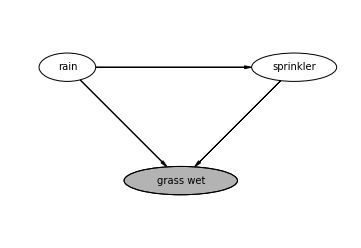

In [2]:
pgm = daft.PGM([6, 4], origin=[2, 1])
pgm.add_node(daft.Node('r', 'rain', 3, 4, aspect=2))
pgm.add_node(daft.Node('s', 'sprinkler', 7, 4, aspect=3))
pgm.add_node(daft.Node('w', 'grass wet', 5, 2, aspect=4, observed=True))
pgm.add_edge('r', 's')
pgm.add_edge('r', 'w')
pgm.add_edge('s', 'w')
pgm.render()

Using some observations about whether it has rained, whether the sprinkler has been on, and whether the grass is wet, fit the conditional probability table values for the Bayesian network [above](https://en.wikipedia.org/wiki/Bayesian_network#Example).

In [6]:
# set the observations
has_rained =   np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1])
sprinkler_on = np.array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
grass_wet =    np.array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    # conditional probability for s
    sprinkrain = pm.Uniform('sprinkrain', 0., 1.)
    sprinknorain = pm.Uniform('sprinknorain', 0., 1.)
    
    psprinkrain = pm.Bernoulli('psprinkrain', sprinkrain,
                               observed=(has_rained & sprinkler_on))
    psprinknorain = pm.Bernoulli('psprinknorain', sprinknorain,
                                 observed=(sprinkler_on & ~has_rained))

    wetsprinkrain = pm.Uniform('wetsprinkrain', 0., 1.)
    wetsprinknorain = pm.Uniform('wetsprinknorain', 0., 1.)
    wetnosprinkrain = pm.Uniform('wetnosprinkrain', 0., 1.)
    wetnosprinknorain = pm.Uniform('wetnosprinknorain', 0., 1.)
    
    pwetsprinkrain = pm.Bernoulli('pwetsprinkrain', wetsprinkrain,
                                  observed=(grass_wet & sprinkler_on & has_rained))
    pwetsprinknorain = pm.Bernoulli('pwetsprinknorain', wetsprinknorain,
                                    observed=(grass_wet & sprinkler_on & ~has_rained))
    pwetnosprinkrain = pm.Bernoulli('pwetnosprinkrain', wetnosprinkrain,
                                    observed=(grass_wet & has_rained & ~sprinkler_on))
    pwetnosprinknorain = pm.Bernoulli('pwetnosprinknorain', wetnosprinknorain,
                                      observed=(grass_wet & ~has_rained & ~sprinkler_on))
    
    trace = pm.sample(1000, tune=2000, discard_tuned_samples=True, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [wetnosprinknorain, wetnosprinkrain, wetsprinknorain, wetsprinkrain, sprinknorain, sprinkrain, prain]
100%|██████████| 3000/3000 [09:27<00:00,  5.15it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [27]:
np.array(has_rained) & np.array(sprinkler_on)

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

(array([ 23., 110., 186., 133., 173., 136.,  55.,  77.,  85.,  22.]),
 array([0.28791386, 0.32313772, 0.35836158, 0.39358544, 0.4288093 ,
        0.46403317, 0.49925703, 0.53448089, 0.56970475, 0.60492861,
        0.64015247]),
 <a list of 10 Patch objects>)

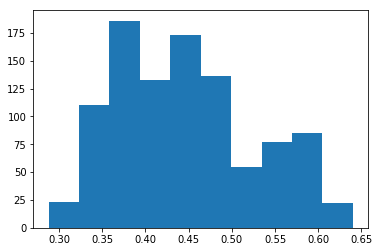

In [7]:
pl.hist(trace['prain'])

In [24]:
np.sum(has_rained)/len(has_rained)

0.5

Following the example [here](https://gist.github.com/cs224/9a19b4ba2c7511e317be90c32a4d40d7#file-pymc3_rain_sprinkler_grass_simple_bayesian_network_with_evidence-py) add in prediction variables.

In [9]:
# set the observations
has_rained =   np.array([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1])
sprinkler_on = np.array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0])
grass_wet =    np.array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1])

# new observation (grass is wet)
new_grass_wet = np.array([1])

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    psprinkler = pm.Uniform('psprinker', 0.0, 1.0)  # prior on probability of sprinkler on
    sprinkler = pm.Bernoulli('sprinkler', psprinkler, observed=sprinkler_on)
    
    pwet = pm.Uniform('pwet', 0.0, 1.0)  # prior on probability of grass being wet
    wet = pm.Bernoulli('wet', pwet, observed=grass_wet)
    
    # conditional probability for sprinkler
    sprinkrain = pm.Uniform('sprinkrain', 0., 1.)
    sprinknorain = pm.Uniform('sprinknorain', 0., 1.)
    
    psprinkrain = pm.Bernoulli('psprinkrain', sprinkrain,
                               observed=(has_rained & sprinkler_on))
    psprinknorain = pm.Bernoulli('psprinknorain', sprinknorain,
                                 observed=(sprinkler_on & ~has_rained))
    
    wetsprinkrain = pm.Uniform('wetsprinkrain', 0., 1.)
    wetsprinknorain = pm.Uniform('wetsprinknorain', 0., 1.)
    wetnosprinkrain = pm.Uniform('wetnosprinkrain', 0., 1.)
    wetnosprinknorain = pm.Uniform('wetnosprinknorain', 0., 1.)
    
    pwetsprinkrain = pm.Bernoulli('pwetsprinkrain', wetsprinkrain,
                                  observed=(grass_wet & sprinkler_on & has_rained))
    pwetsprinknorain = pm.Bernoulli('pwetsprinknorain', wetsprinknorain,
                                    observed=(grass_wet & sprinkler_on & ~has_rained))
    pwetnosprinkrain = pm.Bernoulli('pwetnosprinkrain', wetnosprinkrain,
                                    observed=(grass_wet & has_rained & ~sprinkler_on))
    pwetnosprinknorain = pm.Bernoulli('pwetnosprinknorain', wetnosprinknorain,
                                      observed=(grass_wet & ~has_rained & ~sprinkler_on))
    
    # probability of sprinkler being on
    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(rain, sprinkrain, sprinknorain))
    
    # probability of grass being wet
    grass_wet_p = pm.Deterministic('grass_wet_p', pm.math.switch(rain,
                                                                 pm.math.switch(sprinkler, wetsprinkrain, wetnosprinkrain),
                                                                 pm.math.switch(sprinkler, wetsprinknorain, wetnosprinknorain)))

    # grass wet new observation
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p, observed=new_grass_wet, shape=1)
    
    trace = pm.sample(1000, tune=2000, discard_tuned_samples=True, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [wetnosprinknorain, wetnosprinkrain, wetsprinknorain, wetsprinkrain, sprinknorain, sprinkrain, pwet, psprinker, prain]
100%|██████████| 3000/3000 [11:25<00:00,  4.26it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


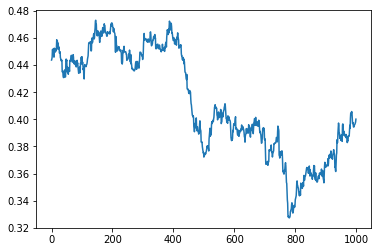

In [11]:
pl.plot(trace['prain'])

Build up the model to check if it's correct. First, just check that I can correctly estimate the probability that it's rained from a set of "observations".

In [54]:
# set "true" probability of rain
true_rain = 0.41

# set number of previous "observations"
nobs = 1000

# set the observations
has_rained = bernoulli.rvs(true_rain, size=nobs)

# is wanting to add missing samples, one could do, e.g.,
#has_rained[20] = -1  # add missing samples as -1
#has_rained = np.ma.masked_values(has_rained, value=-1)  # create masked array
# NOTE: this gives a Theano error if you try it!

# fit the conditional probability distributions
with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    # the following would be equivalent in this case with all observations being present,
    # but would not be as good if there were missing observations as the missing observations
    # would have to be dropped rather than being imputed (which can be done for the Bernoulli
    # approach)
    # rain = pm.Binomial('rain', n=nobs, p=prain, observed=np.sum(has_rained))

    trace = pm.sample(2000, tune=6000, discard_tuned_samples=True, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prain]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2076.34draws/s]


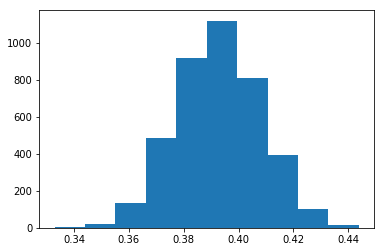

In [55]:
pl.hist(trace['prain']);

In [56]:
print(np.mean(has_rained))
print(np.mean(trace['prain']))

0.393
0.39280248285100433


In [49]:
np.std(trace['prain'])

0.01568406060404906

(array([   6.,   44.,  164.,  552., 1021., 1070.,  815.,  263.,   58.,
           7.]),
 array([0.51345145, 0.52498316, 0.53651487, 0.54804658, 0.55957829,
        0.57111   , 0.58264171, 0.59417342, 0.60570513, 0.61723684,
        0.62876855]),
 <a list of 10 Patch objects>)

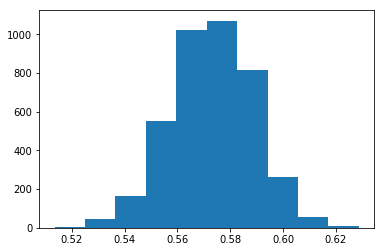

In [50]:
pl.hist(1.-trace['prain'])

Now, check that I can estimate the probabilities that it rains, the sprinkler is on when it's raining, and the spinkler is on when it's not raining.

In [57]:
# set "true" probability of rain
true_rain = 0.41

# set number of previous "observations"
nobs = 1000

# set the observations
has_rained = bernoulli.rvs(true_rain, size=nobs)

# set "true" probability of sprinkler *and* raining
true_sprinkler_rain = 0.01

# set "true" probability of spinkler *and* not raining
true_sprinkler_norain = 0.25

# set the observations
sprinkler_rain = np.zeros(nobs)
sprinkler_norain = np.zeros(nobs)

# draw number from binomial distribution (binomial distribution is the sum of Bernoulli draws)
numsprinkrain = binom.rvs(p=true_sprinkler_rain, n=nobs)
numsprinknorain = binom.rvs(p=true_sprinkler_norain, n=nobs)

# set the observations
rained_idx = np.argwhere(has_rained == 1)
sprinkler_rain[np.random.permutation(rained_idx)[0:numsprinkrain]] = 1
sprinkler_norain[np.random.permutation(rained_idx)[0:numsprinknorain]] = 1

# set new observation that the sprinkler is on (from which to get the probability of also raining?)
obs_sprink_on = np.array([1])

# fit the conditional probability distributions
with pm.Model() as model:
    praintruth = pm.Uniform('praintruth', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    raintruth = pm.Bernoulli('raintruth', p=praintruth, observed=has_rained)
    
    # conditional probability for sprinkler
    psprinkraintruth = pm.Uniform('psprinkraintruth', 0., 1.)
    psprinknoraintruth = pm.Uniform('psprinknoraintruth', 0., 1.)

    sprinkraintruth = pm.Bernoulli('sprinkraintruth', psprinkraintruth,
                               observed=sprinkler_rain)
    sprinknoraintruth = pm.Bernoulli('sprinknorain', psprinknoraintruth,
                                 observed=sprinkler_norain)

    # set variables based on "new observation"
    newobsrain = pm.Bernoulli('newobsrain', praintruth)  # samples that will provide the probability of rain given the new observation
    pnewobssprinkler = pm.Deterministic('pnewobssprinkler', pm.math.switch(newobsrain, psprinkraintruth, psprinknoraintruth))
    newobssprinkler = pm.Bernoulli('newobssprinkler', pnewobssprinkler, observed=obs_sprink_on)  # new observation that the sprinkler is on

    trace = pm.sample(2000, tune=6000, discard_tuned_samples=True, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [psprinknoraintruth, psprinkraintruth, praintruth]
>BinaryGibbsMetropolis: [newobsrain]
Sampling 2 chains: 100%|██████████| 16000/16000 [00:15<00:00, 1005.97draws/s]


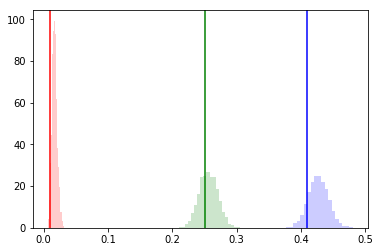

In [58]:
pl.hist(trace['praintruth'], bins=20, density=True, color='b', alpha=0.2);
pl.axvline(true_rain, color='b')
pl.hist(trace['psprinkraintruth'], bins=20, density=True, color='r', alpha=0.2);
pl.axvline(true_sprinkler_rain, color='r')
pl.hist(trace['psprinknoraintruth'], bins=20, density=True, color='g', alpha=0.2);
pl.axvline(true_sprinkler_norain, color='g')

The values in `trace['newobsrain']` are Bernoulli draws (zeros or ones) using the probability distribution that it rains (based on "previous" observations). Therefore, given the new observation that the sprinkler is on, the ratio of the numbers of ones to the total number of draws give the probability (which you can get using `np.mean`) that it also rained.

In [59]:
print('Probability that it rained, given a new observation that '
      'the sprinker was on: {}'.format(np.mean(trace['newobsrain'])))
print('Probability that it did not rain, given a new observation that '
      'the sprinker was on: {}'.format(1.-np.mean(trace['newobsrain'])))

Probability that it rained, given a new observation that the sprinker was on: 0.04675
Probability that it did not rain, given a new observation that the sprinker was on: 0.95325


In [7]:
# copied from https://gist.github.com/cs224/9a19b4ba2c7511e317be90c32a4d40d7#file-pymc3_rain_sprinkler_grass_simple_bayesian_network_with_evidence-py
# for reference 

niter = 10000  # 10000
tune = 5000  # 5000

model = pm.Model()

with model:
    tv = [1]
    rain = pm.Bernoulli('rain', 0.2, shape=1, testval=tv)
    sprinkler_p = pm.Deterministic('sprinkler_p', pm.math.switch(rain, 0.01, 0.40))
    sprinkler = pm.Bernoulli('sprinkler', sprinkler_p, shape=1, testval=tv)
    grass_wet_p = pm.Deterministic('grass_wet_p', pm.math.switch(rain, pm.math.switch(sprinkler, 0.99, 0.80), pm.math.switch(sprinkler, 0.90, 0.0)))
    grass_wet = pm.Bernoulli('grass_wet', grass_wet_p, observed=np.array([1]), shape=1)

    trace = pm.sample(20000, step=[pm.BinaryGibbsMetropolis([rain, sprinkler])], tune=tune, random_seed=124)


Multiprocess sampling (2 chains in 2 jobs)
BinaryGibbsMetropolis: [rain, sprinkler]
Sampling 2 chains: 100%|██████████| 50000/50000 [00:10<00:00, 4679.82draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [65]:
# set "true" probability of rain
true_rain = 0.41

# set number of previous "observations"
nobs = 1000

# set the observations
has_rained = bernoulli.rvs(true_rain, size=nobs)

# set "true" probability of sprinkler *and* raining
true_sprinkler_rain = 0.01

# set "true" probability of spinkler *and* not raining
true_sprinkler_norain = 0.25

# set the observations
sprinkler_rain = np.zeros(nobs)
sprinkler_norain = np.zeros(nobs)

# draw number from binomial distribution (binomial distribution is the sum of Bernoulli draws)
numsprinkrain = binom.rvs(p=true_sprinkler_rain, n=nobs)
numsprinknorain = binom.rvs(p=true_sprinkler_norain, n=nobs)

# set the observations
rained_idx = np.argwhere(has_rained == 1)
sprinkler_rain[np.random.permutation(rained_idx)[0:numsprinkrain]] = 1
sprinkler_norain[np.random.permutation(rained_idx)[0:numsprinknorain]] = 1

# set new observation that the sprinkler is on (from which to get the probability of also raining?)
# Here I set 500 instances of the new observation (it's just still just one observatoin though)
# so that we get 500 set of draws from the Bernoulli distribution (so we can get a distribution
# of the probability that it's raining it the sprinkler's on)
obs_sprink_on = np.ones(500)

model = pm.Model()

# fit the conditional probability distributions
with model:
    praintruth = pm.Uniform('praintruth', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    raintruth = pm.Bernoulli('raintruth', p=praintruth, observed=has_rained)
    
    # conditional probability for sprinkler
    psprinkraintruth = pm.Uniform('psprinkraintruth', 0., 1.)
    psprinknoraintruth = pm.Uniform('psprinknoraintruth', 0., 1.)

    sprinkraintruth = pm.Bernoulli('sprinkraintruth', psprinkraintruth,
                               observed=sprinkler_rain)
    sprinknoraintruth = pm.Bernoulli('sprinknorain', psprinknoraintruth,
                                 observed=sprinkler_norain)

    # set variables based on "new observation"
    newobsrain = pm.Bernoulli('newobsrain', praintruth, shape=len(obs_sprink_on))  # samples that will provide the probability of rain given the new observation
    pnewobssprinkler = pm.Deterministic('pnewobssprinkler', pm.math.switch(newobsrain, psprinkraintruth, psprinknoraintruth))
    newobssprinkler = pm.Bernoulli('newobssprinkler', pnewobssprinkler, observed=obs_sprink_on)  # new observation that the sprinkler is on

    trace = pm.sample(2000, tune=6000, discard_tuned_samples=True, chains=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [psprinknoraintruth, psprinkraintruth, praintruth]
>BinaryGibbsMetropolis: [newobsrain]
Sampling 2 chains: 100%|██████████| 16000/16000 [08:06<00:00, 32.86draws/s]


In [66]:
trace['newobsrain'].shape

(4000, 500)

In [67]:
pnewrain = np.zeros(trace['newobsrain'].shape[1])
for i in range(trace['newobsrain'].shape[1]):
    pnewrain[i] = np.mean(trace['newobsrain'][:,i])

(array([  5.,  13.,  59., 114., 113., 119.,  53.,  18.,   5.,   1.]),
 array([0.0095, 0.0111, 0.0127, 0.0143, 0.0159, 0.0175, 0.0191, 0.0207,
        0.0223, 0.0239, 0.0255]),
 <a list of 10 Patch objects>)

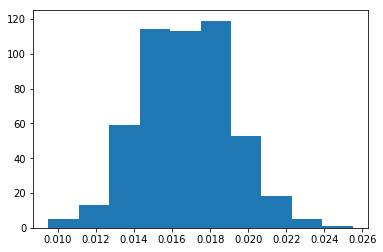

In [68]:
pl.hist(pnewrain)

In [81]:
from theano import shared, config
import theano.tensor as T

# set "true" probability of rain
true_rain = 0.41

# set number of previous "observations"
nobs = 1000

# set the observations
has_rained = bernoulli.rvs(true_rain, size=nobs)

# set "true" probability of sprinkler *and* raining
true_sprinkler_rain = 0.01

# set "true" probability of spinkler *and* not raining
true_sprinkler_norain = 0.25

# set the observations
sprinkler_rain = np.zeros(nobs)
sprinkler_norain = np.zeros(nobs)

# draw number from binomial distribution (binomial distribution is the sum of Bernoulli draws)
numsprinkrain = binom.rvs(p=true_sprinkler_rain, n=nobs)
numsprinknorain = binom.rvs(p=true_sprinkler_norain, n=nobs)

# set the observations
rained_idx = np.argwhere(has_rained == 1)
sprinkler_rain[np.random.permutation(rained_idx)[0:numsprinkrain]] = 1
sprinkler_norain[np.random.permutation(rained_idx)[0:numsprinknorain]] = 1

# set new observation that the sprinkler is on (from which to get the probability of also raining?)
obs_sprink_on = shared(np.ones(1, dtype='int64'))
print(obs_sprink_on)

model = pm.Model()

# fit the conditional probability distributions
with model:
    praintruth = pm.Uniform('praintruth', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    raintruth = pm.Bernoulli('raintruth', p=praintruth, observed=has_rained)
    
    # conditional probability for sprinkler
    psprinkraintruth = pm.Uniform('psprinkraintruth', 0., 1.)
    psprinknoraintruth = pm.Uniform('psprinknoraintruth', 0., 1.)

    sprinkraintruth = pm.Bernoulli('sprinkraintruth', psprinkraintruth,
                               observed=sprinkler_rain)
    sprinknoraintruth = pm.Bernoulli('sprinknorain', psprinknoraintruth,
                                 observed=sprinkler_norain)

    # set variables based on "new observation"
    newobsrain = pm.Bernoulli('newobsrain', praintruth, shape=len(obs_sprink_on.get_value()))  # samples that will provide the probability of rain given the new observation
    pnewobssprinkler = pm.Deterministic('pnewobssprinkler', pm.math.switch(newobsrain, psprinkraintruth, psprinknoraintruth))
    newobssprinkler = pm.Bernoulli('newobssprinkler', pnewobssprinkler, observed=obs_sprink_on)  # new observation that the sprinkler is on

    trace = pm.sample(2000, tune=6000, discard_tuned_samples=True, chains=2)

<TensorType(int64, vector)>


TypeError: Cannot convert Type TensorType(int64, vector) (of Variable newobsrain_shared__) into Type TensorType(int64, (True,)). You can try to manually convert newobsrain_shared__ into a TensorType(int64, (True,)).

In [5]:
import theano
import pymc3

print(theano.__version__)
print(pymc3.__version__)

# set "true" probability of rain
true_rain = 0.41

# set number of previous "observations"
nobs = 1000

# set the observations
has_rained = bernoulli.rvs(true_rain, size=nobs)

# try adding a missing samples, e.g.,
has_rained[20] = -1  # add missing samples as -1
has_rained = np.ma.masked_values(has_rained, value=-1).astype('bool')  # create masked array

with pm.Model() as model:
    prain = pm.Uniform('prain', 0.0, 1.0)  # prior on probability of rain

    # distribution of prain given the number of observed times it has rained
    rain = pm.Bernoulli('rain', p=prain, observed=has_rained)

    trace = pm.sample(2000, tune=6000, discard_tuned_samples=True, chains=2)

1.0.3
3.6


/home/matthew/.conda/envs/survival/lib/python3.6/site-packages/pymc3/model.py:1266: UserWarning: Data in rain contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)


TypeError: Cannot convert Type TensorType(int64, vector) (of Variable rain_missing_shared__) into Type TensorType(int64, (True,)). You can try to manually convert rain_missing_shared__ into a TensorType(int64, (True,)).

In [4]:
has_rained.astype('bool')

masked_array(data=[True, True, False, True, True, False, False, False,
                   False, True, False, False, False, False, False, False,
                   False, True, False, False, --, False, True, False,
                   True, True, False, False, False, False, True, False,
                   False, False, False, False, False, True, False, True,
                   True, False, True, False, False, False, False, False,
                   True, False, False, False, False, True, True, False,
                   False, True, False, False, False, True, False, False,
                   True, False, False, False, False, True, False, False,
                   True, False, True, False, False, False, False, True,
                   True, False, True, True, False, False, True, False,
                   False, False, False, True, True, True, False, False,
                   True, False, False, False, False, True, True, False,
                   False, True, True, True, False, True, False